In [ ]:
!python -m spacy download en_core_web_sm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GATConv
from transformers import DistilBertModel, DistilBertTokenizer, get_linear_schedule_with_warmup,DistilBertTokenizerFast, AutoModel, AutoTokenizer
from torch.optim import AdamW
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score,accuracy_score,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from statsmodels.stats.contingency_tables import mcnemar
from tqdm import tqdm
import os
import requests
import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

nlp = spacy.load("en_core_web_sm")
print("spaCy loaded")

Device: cuda
spaCy loaded


Successfully downloaded TRAIN_FILE.TXT
Successfully downloaded TEST_FILE_FULL.TXT
Loaded 8000 train samples
Loaded 2717 test samples
============================== DATA ANALYSIS ==============================


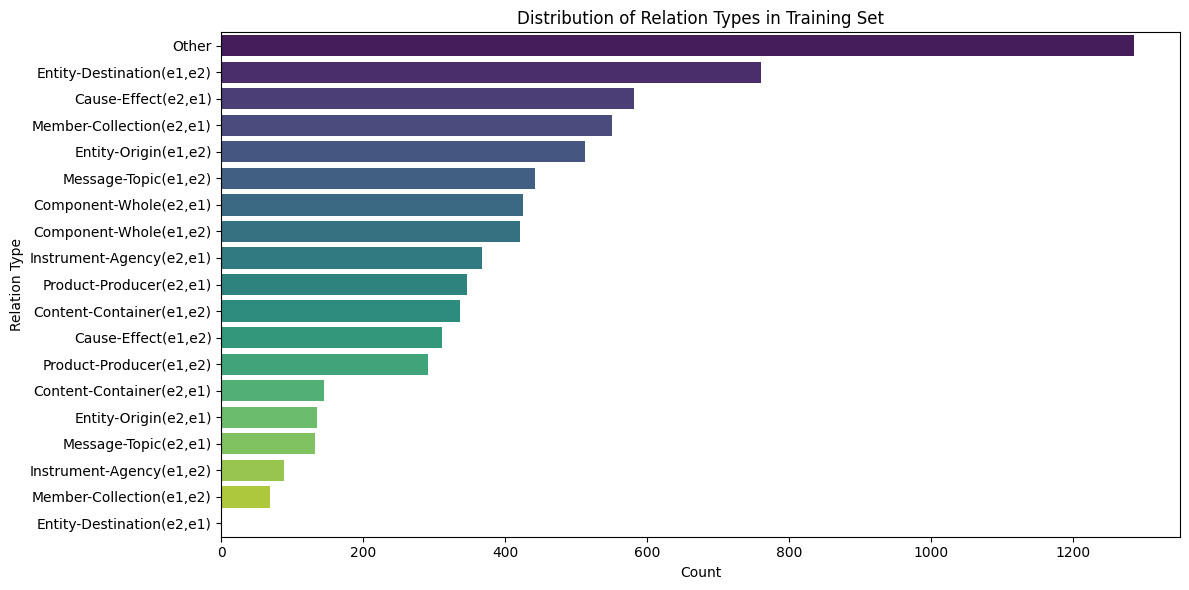

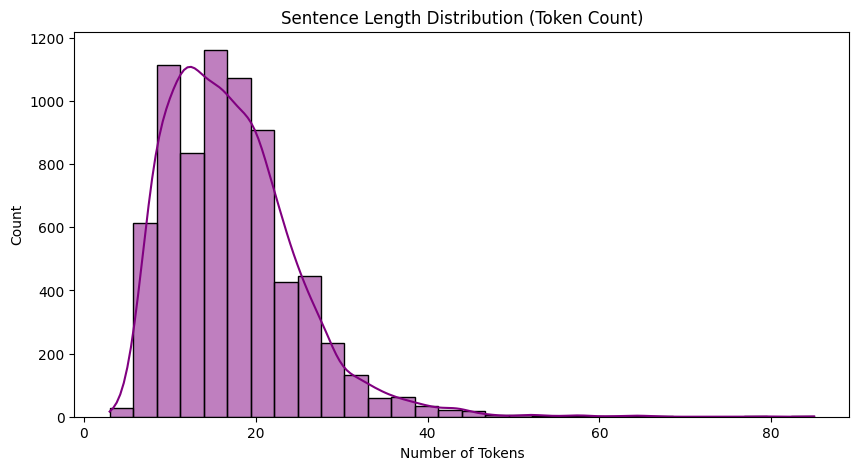

In [ ]:
def download_semeval_data():
    """
    Downloads SemEval-2010 Task 8 train and test files if they don't exist.
    """
    base_url = "https://raw.githubusercontent.com/SeoSangwoo/Attention-Based-BiLSTM-relation-extraction/master/SemEval2010_task8_all_data"

    files = {
        'TRAIN_FILE.TXT': f"{base_url}/SemEval2010_task8_training/TRAIN_FILE.TXT",
        'TEST_FILE_FULL.TXT': f"{base_url}/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT"
    }

    for filename, url in files.items():
        if not os.path.exists(filename):
            print(f"Downloading {filename}...")
            try:
                response = requests.get(url)
                response.raise_for_status()
                with open(filename, 'w', encoding='utf-8') as f:
                    f.write(response.text)
                print(f"Successfully downloaded {filename}")
            except Exception as e:
                print(f"Error downloading {filename}: {e}")
        else:
            print(f"{filename} already exists.")

def load_semeval_data(file_path):
    sentences, relations = [], []

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} not found. Please check download.")

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line:
            i += 1
            continue

        if '"' in line:
            start = line.find('"') + 1
            end = line.rfind('"')
            sentence = line[start:end]

            if i + 1 < len(lines):
                relation = lines[i+1].strip()
                if relation and not relation.startswith('Comment'):
                    sentences.append(sentence)
                    relations.append(relation)
                i += 2
            else:
                i += 1
        else:
            i += 1

    return sentences, relations

download_semeval_data()

try:
    train_sentences, train_relations = load_semeval_data('TRAIN_FILE.TXT')
    test_sentences, test_relations = load_semeval_data('TEST_FILE_FULL.TXT')

    print(f"Loaded {len(train_sentences)} train samples")
    print(f"Loaded {len(test_sentences)} test samples")

    train_sentences, val_sentences, train_relations, val_relations = train_test_split(
        train_sentences, train_relations, test_size=0.1, random_state=42
    )

    print("="*30 + " DATA ANALYSIS " + "="*30)

    plt.figure(figsize=(12, 6))
    sns.countplot(y=train_relations, order=pd.Series(train_relations).value_counts().index, palette='viridis')
    plt.title("Distribution of Relation Types in Training Set")
    plt.xlabel("Count")
    plt.ylabel("Relation Type")
    plt.tight_layout()
    plt.show()

    token_counts = [len(s.split()) for s in train_sentences]
    plt.figure(figsize=(10, 5))
    sns.histplot(token_counts, bins=30, kde=True, color='purple')
    plt.title("Sentence Length Distribution (Token Count)")
    plt.xlabel("Number of Tokens")
    plt.show()

    print("="*80)

except Exception as e:
    print(f"\nAn error occurred: {e}")

In [ ]:
RELATION_LABELS = [
    'Cause-Effect(e1,e2)', 'Cause-Effect(e2,e1)',
    'Instrument-Agency(e1,e2)', 'Instrument-Agency(e2,e1)',
    'Product-Producer(e1,e2)', 'Product-Producer(e2,e1)',
    'Content-Container(e1,e2)', 'Content-Container(e2,e1)',
    'Entity-Origin(e1,e2)', 'Entity-Origin(e2,e1)',
    'Entity-Destination(e1,e2)', 'Entity-Destination(e2,e1)',
    'Component-Whole(e1,e2)', 'Component-Whole(e2,e1)',
    'Member-Collection(e1,e2)', 'Member-Collection(e2,e1)',
    'Message-Topic(e1,e2)', 'Message-Topic(e2,e1)',
    'Other'
]
relation_to_id = {rel: idx for idx, rel in enumerate(RELATION_LABELS)}
id_to_relation = {idx: rel for rel, idx in relation_to_id.items()}
print("Computing class weights for Imbalance handling")
train_relation_ids = np.array([relation_to_id[r] for r in train_relations])
class_weights_full = compute_class_weight(class_weight='balanced',classes=np.unique(train_relation_ids),y=train_relation_ids)
alpha=0.4
class_weights = 1.0 + alpha *(class_weights_full-1.0)
weights_tensor = torch.tensor(class_weights,dtype=torch.float).to(device)
print("Weights computed successfully")

def extract_entities(sentence):
    e1_start = sentence.find('<e1>') + 4
    e1_end = sentence.find('</e1>')
    e1 = sentence[e1_start:e1_end]
    e2_start = sentence.find('<e2>') + 4
    e2_end = sentence.find('</e2>')
    e2 = sentence[e2_start:e2_end]
    clean = sentence.replace('<e1>', '').replace('</e1>', '')
    clean = clean.replace('<e2>', '').replace('</e2>', '')
    return clean, e1, e2

def build_dependency_graph(sentence):
    doc = nlp(sentence)
    edges = []
    for token in doc:
        if token.head.i != token.i:
            edges.append([token.i, token.head.i])
            edges.append([token.head.i, token.i])
    if len(edges) == 0:
        for i in range(len(doc)):
            for j in range(len(doc)):
                if i != j:
                    edges.append([i, j])
    edges = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.zeros((2, 0), dtype=torch.long)
    return edges, len(doc)

test_sent = train_sentences[0]
clean, e1, e2 = extract_entities(test_sent)
print(f"\nExample Sentence: {clean}")
print(f"  E1: {e1}, E2: {e2}")
edges, num_nodes = build_dependency_graph(clean)
print(f"  Dependency Graph: {num_nodes} nodes, {edges.shape[1]} edges")
doc = nlp(clean)
print("\n  Dependency Parse Tree:")
for token in doc:
    print(f"    {token.text} → {token.head.text} (relation: {token.dep_})")

Computing class weights for Imbalance handling
Weights computed successfully

Example Sentence: Auto EQ is a powerful sound tuning feature which uses a microphone to monitor and analyse the acoustics inside the car.
  E1: acoustics, E2: car
  Dependency Graph: 22 nodes, 42 edges

  Dependency Parse Tree:
    Auto → EQ (relation: compound)
    EQ → is (relation: nsubj)
    is → is (relation: ROOT)
    a → feature (relation: det)
    powerful → feature (relation: amod)
    sound → tuning (relation: compound)
    tuning → feature (relation: compound)
    feature → is (relation: attr)
    which → uses (relation: nsubj)
    uses → feature (relation: relcl)
    a → microphone (relation: det)
    microphone → uses (relation: dobj)
    to → monitor (relation: aux)
    monitor → uses (relation: xcomp)
    and → monitor (relation: cc)
    analyse → monitor (relation: conj)
    the → acoustics (relation: det)
    acoustics → analyse (relation: dobj)
    inside → analyse (relation: prep)
    the →

In [ ]:
def preprocess_graphs(sentences):
    graph_data = []
    print("Preprocessing Dependency graphs")
    for sent in tqdm(sentences,desc="Building graphs"):
        clean_sent,_,_ = extract_entities(sent)
        edges,num_nodes = build_dependency_graph(clean_sent)
        graph_data.append({'edge_index': edges, 'num_nodes': num_nodes})
    return graph_data

print("Generating graphs for all splits")
train_graphs = preprocess_graphs(train_sentences)
val_graphs = preprocess_graphs(val_sentences)
test_graphs = preprocess_graphs(test_sentences)

class SemEvalDataset(Dataset):
    def __init__(self,sentences,relations,graphs,relation_to_id,tokenizer,max_length=128):
        self.sentences = sentences
        self.relations = relations
        self.graphs = graphs
        self.relation_to_id = relation_to_id
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        relation = self.relations[idx]
        clean_sent,e1_text,e2_text = extract_entities(sentence)

        encoded = self.tokenizer(clean_sent,max_length = self.max_length,truncation = True,padding='max_length',return_tensors = 'pt',return_offsets_mapping = True)
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)

        offset_mapping = encoded['offset_mapping'].squeeze(0)
        e1_start = clean_sent.lower().find(e1_text.lower())
        e2_start = clean_sent.lower().find(e2_text.lower())

        e1_token_id = 1
        e2_token_id = 2
        for i,(start,end) in enumerate(offset_mapping):
            if start<=e1_start<end:
                e1_token_id = i
            if start<=e2_start<end:
                e2_token_id = i
        graph = self.graphs[idx]
        edge_index = graph['edge_index']
        num_nodes = graph['num_nodes']

        label = self.relation_to_id[relation]

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'edge_index': edge_index,
            'num_nodes': num_nodes,
            'label': torch.tensor(label, dtype=torch.long),
            'e1_idx':e1_token_id,
            'e2_idx':e2_token_id
        }

def collate(batch):
    batch_out = {}
    for key in ['input_ids','attention_mask','label']:
        batch_out[key] = torch.stack([x[key] for x in batch])
    batch_out['edge_index'] = [x['edge_index'] for x in batch]
    batch_out['num_nodes'] = [x['num_nodes'] for x in batch]
    batch_out['e1_idx'] = [x['e1_idx'] for x in batch]
    batch_out['e2_idx'] = [x['e2_idx'] for x in batch]
    return batch_out

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_dataset = SemEvalDataset(train_sentences,train_relations,train_graphs,relation_to_id,tokenizer)
val_dataset = SemEvalDataset(val_sentences,val_relations,val_graphs,relation_to_id,tokenizer)
test_dataset = SemEvalDataset(test_sentences,test_relations,test_graphs,relation_to_id,tokenizer)
print(f"Train:{len(train_dataset)}, val:{len(val_dataset)},Test:{len(test_dataset)}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size,shuffle=True,collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size,shuffle=False,collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size,shuffle=False,collate_fn=collate)
print(f"Dataloaders created with (batch size:{batch_size})")

Generating graphs for all splits
Preprocessing Dependency graphs


Building graphs: 100%|██████████| 7200/7200 [01:09<00:00, 104.25it/s]


Preprocessing Dependency graphs


Building graphs: 100%|██████████| 800/800 [00:08<00:00, 94.21it/s] 


Preprocessing Dependency graphs


Building graphs: 100%|██████████| 2717/2717 [00:19<00:00, 138.21it/s]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Train:7200, val:800,Test:2717
Dataloaders created with (batch size:32)


In [ ]:
print("\n" + "="*60)
print("BASELINE: MAJORITY CLASS (The 'Floor')")
print("="*60)
train_counts_series = pd.Series(train_relations).value_counts()
majority_label_text = train_counts_series.index[0]
majority_label_id = relation_to_id[majority_label_text]
print(f"Most frequent relation:'{majority_label_text}' ({train_counts_series.iloc[0]} samples)")
test_label_ids = [relation_to_id[r] for r in test_relations]
majority_preds = [majority_label_id] * len(test_label_ids)
majority_acc = accuracy_score(test_label_ids, majority_preds)
majority_f1 = f1_score(test_label_ids,majority_preds, average='macro', zero_division=0)
print(f"Majority Baseline Accuracy:{majority_acc:.4f}")
print(f"Majority baseline F1(Macro):{majority_f1:.4f}")


BASELINE: MAJORITY CLASS (The 'Floor')
Most frequent relation:'Other' (1287 samples)
Majority Baseline Accuracy:0.1671
Majority baseline F1(Macro):0.0151


In [7]:
def evaluate(model,loader,device,model_name):
    model.eval()
    all_preds,all_labels = [],[]
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(loader,desc=f"Evaluating {model_name}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            edge_indices = batch['edge_index']

            if hasattr(model,'gat1'):
                batch_data = {'e1_idx':batch['e1_idx'],'e2_idx':batch['e2_idx']}
                logits = model(input_ids,attention_mask,edge_indices,batch_data)
            else:
                logits = model(input_ids,attention_mask)

            loss = F.cross_entropy(logits,labels)
            total_loss += loss.item()

            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss/len(loader)
    acc = accuracy_score(all_labels,all_preds)
    f1_macro = f1_score(all_labels,all_preds,average='macro',zero_division=0)
    f1_weighted = f1_score(all_labels,all_preds,average='weighted',zero_division=0)

    return all_preds,all_labels,avg_loss,acc,f1_macro,f1_weighted

def train_epoch(model,loader,optimizer,device,weights,scheduler=None):
    model.train()
    total_loss = 0
    all_preds,all_labels = [],[]
    pbar = tqdm(loader,desc='Training')
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        edge_indices = batch['edge_index']
        optimizer.zero_grad()
        if hasattr(model,'gat1'):
            batch_data = {'e1_idx':batch['e1_idx'],'e2_idx':batch['e2_idx']}
            logits = model(input_ids,attention_mask,edge_indices,batch_data)
        else:
            logits = model(input_ids,attention_mask)

        loss = F.cross_entropy(logits,labels,weight=weights)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()

        if scheduler: scheduler.step()
        total_loss += loss.item()
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix({'loss':loss.item()})
    pbar.close()
    return total_loss / len(loader), accuracy_score(all_labels, all_preds), f1_score(all_labels, all_preds, average='macro', zero_division=0)

In [8]:
class DistilBertBaseline(nn.Module):
    def __init__(self,num_classes=19,hidden_dim = 256,dropout=0.3):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(nn.Dropout(dropout),nn.Linear(self.hidden_size,hidden_dim),nn.ReLU(),nn.Dropout(dropout),nn.Linear(hidden_dim,num_classes))
    def forward(self,input_ids,attention_mask):
        outputs = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        cls_token =  outputs.last_hidden_state[:,0,:]
        logits = self.classifier(cls_token)
        return logits

baseline_model = DistilBertBaseline(num_classes=19)
baseline_model = baseline_model.to(device)
baseline_params = sum(p.numel() for p in baseline_model.parameters())
print(f"Baseline Model:{baseline_params/1e6:.1f}M parameters")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Baseline Model:66.6M parameters


In [ ]:
EPOCHS = 10
print("="*30 + "TRAINING BASELINE"+"="*30)
optimizer_baseline = AdamW(baseline_model.parameters(),lr=2e-5,weight_decay=1e-5)
scheduler_baseline = get_linear_schedule_with_warmup(optimizer_baseline,num_warmup_steps=len(train_loader),num_training_steps=len(train_loader)*EPOCHS)

best_val_f1_baseline = 0
baseline_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss,train_acc,train_f1 = train_epoch(baseline_model,train_loader,optimizer_baseline,device,weights_tensor,scheduler_baseline)
    _,_,val_loss,val_acc,val_f1,_ = evaluate(baseline_model,val_loader,device,"Val")

    baseline_history['train_loss'].append(train_loss)
    baseline_history['train_f1'].append(train_f1)
    baseline_history['val_loss'].append(val_loss)
    baseline_history['val_f1'].append(val_f1)
    print(f"Train Loss: {train_loss:.4f} | Val F1: {val_f1:.4f}")
    if val_f1>best_val_f1_baseline:
        best_val_f1_baseline = val_f1
        torch.save(baseline_model.state_dict(),'baseline_best.pth')
        print("Saved Best Baseline")

baseline_model.load_state_dict(torch.load('baseline_best.pth'))
print('\nEvaluating Baseline on Test Set')
baseline_preds,baseline_labels,baseline_loss,baseline_acc,baseline_f1m,baseline_f1w = evaluate(baseline_model,test_loader,device,"Baseline Test")
print(f"Baseline Test F1 (Macro): {baseline_f1m:.4f}")
print(f"Baseline Test F1 (Weighted): {baseline_f1w:.4f}")

==============================TRAINING BASELINE==============================

Epoch 1/10


Evaluating Val: 100%|██████████| 25/25 [00:04<00:00,  5.15it/s]


Train Loss: 2.8157 | Val F1: 0.2226
Saved Best Baseline

Epoch 2/10


Evaluating Val: 100%|██████████| 25/25 [00:04<00:00,  5.18it/s]


Train Loss: 1.9405 | Val F1: 0.5255
Saved Best Baseline

Epoch 3/10


Evaluating Val: 100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


Train Loss: 1.2678 | Val F1: 0.6733
Saved Best Baseline

Epoch 4/10


Evaluating Val: 100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Train Loss: 0.8769 | Val F1: 0.7087
Saved Best Baseline

Epoch 5/10


Evaluating Val: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s]


Train Loss: 0.6427 | Val F1: 0.7354
Saved Best Baseline

Epoch 6/10


Evaluating Val: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s]


Train Loss: 0.4933 | Val F1: 0.7542
Saved Best Baseline

Epoch 7/10


Evaluating Val: 100%|██████████| 25/25 [00:04<00:00,  5.14it/s]


Train Loss: 0.3657 | Val F1: 0.7672
Saved Best Baseline

Epoch 8/10


Evaluating Val: 100%|██████████| 25/25 [00:04<00:00,  5.01it/s]


Train Loss: 0.2971 | Val F1: 0.7466

Epoch 9/10


Evaluating Val: 100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Train Loss: 0.2482 | Val F1: 0.7616

Epoch 10/10


Evaluating Val: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s]


Train Loss: 0.2250 | Val F1: 0.7667

Evaluating Baseline on Test Set


Evaluating Baseline Test: 100%|██████████| 85/85 [00:17<00:00,  4.99it/s]

Baseline Test F1 (Macro): 0.6919
Baseline Test F1 (Weighted): 0.7362


HYPERPARAMETER TUNING (ABLATION)

--- Testing GAT with 4 Attention Heads,Lr=0.001 ---


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating Val: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


Result:0.7843

--- Testing GAT with 4 Attention Heads,Lr=0.0005 ---


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating Val: 100%|██████████| 25/25 [00:06<00:00,  3.59it/s]


Result:0.7848

--- Testing GAT with 8 Attention Heads,Lr=0.001 ---


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating Val: 100%|██████████| 25/25 [00:07<00:00,  3.54it/s]


Result:0.8017

--- Testing GAT with 8 Attention Heads,Lr=0.0005 ---


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating Val: 100%|██████████| 25/25 [00:07<00:00,  3.57it/s]

Result:0.7977
Best config heads=8,LR=0.001

------------------------------RESULTS ------------------------------


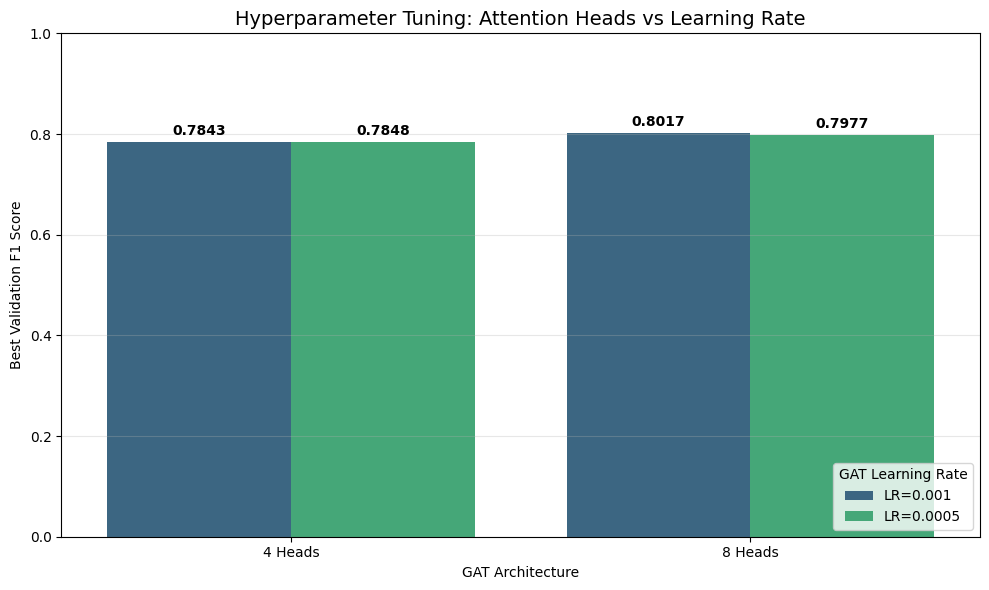

In [ ]:
print("="*40)
print("HYPERPARAMETER TUNING (ABLATION)")
print("="*40)
EPOCHS = 3
candidate_heads = [4, 8]
candidate_gat_lr = [1e-3, 5e-4]
best_config = {'heads':8,'lr':1e-3}
best_f1_overall = -1
best_f1_tuning = 0
tuning_results = []

for heads in candidate_heads:
    for lr in candidate_gat_lr:
        print(f"\n--- Testing GAT with {heads} Attention Heads,Lr={lr} ---")
        temp_model = DistilBERTGATModel(num_classes=19, gat_heads=heads).to(device)
        temp_opt = AdamW([
            {'params':temp_model.bert.parameters(),'lr':2e-5},
            {'params':temp_model.gat1.parameters(),'lr':lr},
            {'params':temp_model.gat2.parameters(),'lr':lr},
            {'params':temp_model.classifier.parameters(),'lr':lr}
        ])
        temp_sched = get_linear_schedule_with_warmup(temp_opt, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)
        curr_best_f1 = 0

        for epoch in range(EPOCHS):
            _ = train_epoch(temp_model, train_loader, temp_opt, device, weights_tensor,temp_sched)
            _,_,_,_,val_f1,_ = evaluate(temp_model, val_loader, device,"Val")
            if val_f1 > curr_best_f1:
                curr_best_f1 = val_f1

        print(f"Result:{curr_best_f1:.4f}")
        tuning_results.append({'Heads':f"{heads} Heads",'LR':f"LR={lr}",'F1':curr_best_f1})
        if curr_best_f1>best_f1_tuning:
            best_f1_tuning = curr_best_f1
            best_config = {'heads':heads,'lr':lr}
print(f"Best config heads={best_config['heads']},LR={best_config['lr']}")

print("\n" + "-"*30 + "RESULTS " + "-"*30)
df_tuning = pd.DataFrame(tuning_results)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_tuning, x='Heads', y='F1', hue='LR', palette='viridis')
plt.ylim(0, 1.0)
plt.title('Hyperparameter Tuning: Attention Heads vs Learning Rate', fontsize=14)
plt.ylabel('Best Validation F1 Score')
plt.xlabel('GAT Architecture')
plt.legend(title='GAT Learning Rate',loc='lower right')
plt.grid(axis='y',alpha=0.3)
for container in ax.containers:
    ax.bar_label(container,fmt='%.4f',padding=3,fontweight = 'bold')
plt.tight_layout()
plt.show()

In [ ]:
print("="*30 + "TRAINING BERT+GAT"+"="*30)
print(f"Using {best_config['heads']} Attention heads and best learning rate {best_config['lr']}")
EPOCHS = 10
final_gat_model = DistilBERTGATModel(num_classes=19,gat_heads=best_config['heads']).to(device)
optimizer_gat = AdamW([
    {'params':final_gat_model.bert.parameters(),'lr':2e-5},
    {'params':final_gat_model.gat1.parameters(),'lr':best_config['lr']},
    {'params':final_gat_model.gat2.parameters(),'lr':best_config['lr']},
    {'params':final_gat_model.classifier.parameters(),'lr':best_config['lr']}
],weight_decay=1e-3)
scheduler_gat = get_linear_schedule_with_warmup(optimizer_gat,num_warmup_steps=len(train_loader), num_training_steps=len(train_loader)*EPOCHS)
best_val_f1_gat = 0
gat_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss,train_acc,train_f1 = train_epoch(final_gat_model,train_loader,optimizer_gat,device,weights_tensor,scheduler_gat)
    _, _, val_loss, val_acc, val_f1, _ = evaluate(final_gat_model, val_loader, device, "Val")
    gat_history['train_loss'].append(train_loss)
    gat_history['train_f1'].append(train_f1)
    gat_history['val_loss'].append(val_loss)
    gat_history['val_f1'].append(val_f1)
    print(f"Train Loss: {train_loss:.4f} | Val F1: {val_f1:.4f}")
    if val_f1 > best_val_f1_gat:
        best_val_f1_gat = val_f1
        torch.save(final_gat_model.state_dict(),'gat_best.pth')
        print('Saved best GAT')

final_gat_model.load_state_dict(torch.load('gat_best.pth'))
print("\nEvaluating GAT on Test set")
gat_preds,gat_labels,gat_loss,gat_acc,gat_f1m,gat_f1w = evaluate(final_gat_model,test_loader,device,'GAT TEST')
print(f"GAT Test F1 (Macro): {gat_f1m:.4f}")
print(f"GAT Test F1 (Weighted): {gat_f1w:.4f}")

==============================TRAINING BERT+GAT==============================
Using 8 Attention heads and best learning rate 0.001


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Epoch 1/10


Evaluating Val: 100%|██████████| 25/25 [00:06<00:00,  3.59it/s]


Train Loss: 1.9761 | Val F1: 0.6587
Saved best GAT

Epoch 2/10


Evaluating Val: 100%|██████████| 25/25 [00:07<00:00,  3.50it/s]


Train Loss: 0.8470 | Val F1: 0.7577
Saved best GAT

Epoch 3/10


Evaluating Val: 100%|██████████| 25/25 [00:07<00:00,  3.55it/s]


Train Loss: 0.4927 | Val F1: 0.7907
Saved best GAT

Epoch 4/10


Evaluating Val: 100%|██████████| 25/25 [00:06<00:00,  3.64it/s]


Train Loss: 0.2662 | Val F1: 0.8094
Saved best GAT

Epoch 5/10


Evaluating Val: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Train Loss: 0.1473 | Val F1: 0.8069

Epoch 6/10


Evaluating Val: 100%|██████████| 25/25 [00:06<00:00,  3.57it/s]


Train Loss: 0.0826 | Val F1: 0.8043

Epoch 7/10


Evaluating Val: 100%|██████████| 25/25 [00:07<00:00,  3.16it/s]


Train Loss: 0.0413 | Val F1: 0.8062

Epoch 8/10


Evaluating Val: 100%|██████████| 25/25 [00:06<00:00,  3.64it/s]


Train Loss: 0.0256 | Val F1: 0.8089

Epoch 9/10


Evaluating Val: 100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Train Loss: 0.0135 | Val F1: 0.8092

Epoch 10/10


Evaluating Val: 100%|██████████| 25/25 [00:06<00:00,  3.58it/s]


Train Loss: 0.0074 | Val F1: 0.8227
Saved best GAT

Evaluating GAT on Test set


Evaluating GAT TEST: 100%|██████████| 85/85 [00:22<00:00,  3.75it/s]

GAT Test F1 (Macro): 0.7602
GAT Test F1 (Weighted): 0.8017



FINAL MODEL COMPARISON & VISUALIZATION
                Model Accuracy F1(Macro) F1(Weighted) Improvement(vs BERT)
Majority Class(Floor)   0.1671    0.0151       0.0151                  N/A
 DistillBert Baseline   0.7402    0.6919       0.7362                  Ref
      DistillBert+GAT   0.8042    0.7602       0.8017    +6.832 (Macro F1)


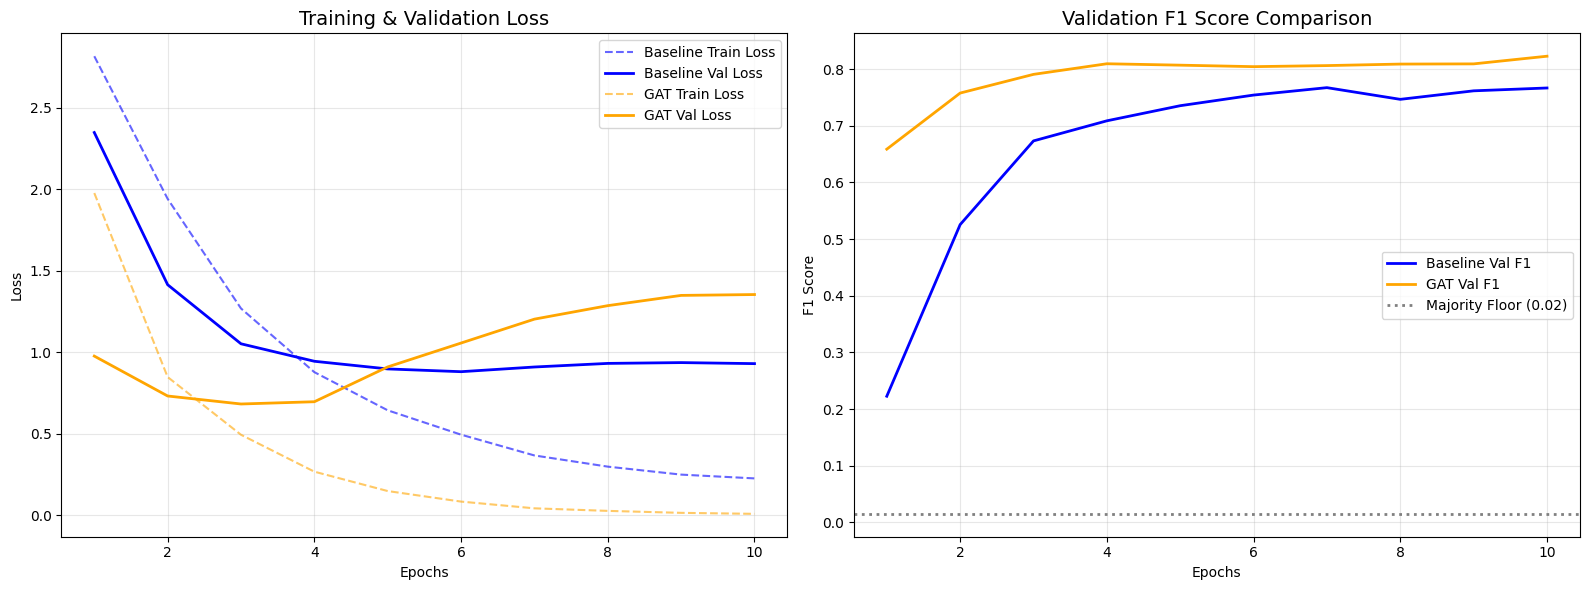

In [ ]:
print("\n" + "="*80)
print("FINAL MODEL COMPARISON & VISUALIZATION")
print("="*80)

improvement_acc = (gat_acc - baseline_acc) * 100
improvement_f1m = (gat_f1m - baseline_f1m) * 100
improvement_f1w = (gat_f1w - baseline_f1w) * 100

comparison = pd.DataFrame({
    'Model':['Majority Class(Floor)','DistillBert Baseline','DistillBert+GAT'],
    'Accuracy':[f'{majority_acc:.4f}',f'{baseline_acc:.4f}',f'{gat_acc:.4f}'],
    'F1(Macro)':[f'{majority_f1:.4f}',f'{baseline_f1m:.4f}',f'{gat_f1m:.4f}'],
    'F1(Weighted)':[f'{majority_f1:.4f}',f'{baseline_f1w:.4f}',f'{gat_f1w:.4f}'],
    'Improvement(vs BERT)':['N/A','Ref',f'{improvement_f1m:+.3f} (Macro F1)']
})

print(comparison.to_string(index=False))
comparison.to_csv('results_comparison.csv', index=False)

epochs_range = range(1, len(baseline_history['train_loss'])+ 1)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(epochs_range, baseline_history['train_loss'], label='Baseline Train Loss', linestyle='--', color='blue', alpha=0.6)
axes[0].plot(epochs_range, baseline_history['val_loss'], label='Baseline Val Loss', color='blue',linewidth=2)
axes[0].plot(epochs_range, gat_history['train_loss'], label='GAT Train Loss', linestyle='--', color='orange', alpha=0.6)
axes[0].plot(epochs_range, gat_history['val_loss'], label='GAT Val Loss', color='orange',linewidth=2)
axes[0].set_title('Training & Validation Loss',fontsize=14)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True,alpha=0.3)

axes[1].plot(epochs_range, baseline_history['val_f1'], label='Baseline Val F1', color='blue',linewidth=2)
axes[1].plot(epochs_range, gat_history['val_f1'], label='GAT Val F1', color='orange',linewidth=2)

axes[1].axhline(y=majority_f1, color='gray', linestyle=':', linewidth=2, label=f'Majority Floor ({majority_f1:.2f})')
axes[1].set_title('Validation F1 Score Comparison',fontsize=14)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('F1 Score')
axes[1].legend()
axes[1].grid(True,alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print("\nClassification Report (GAT):")
print(classification_report(gat_labels, gat_preds, target_names=RELATION_LABELS))


Classification Report (GAT):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.93      0.92       134
      Cause-Effect(e2,e1)       0.88      0.94      0.91       194
 Instrument-Agency(e1,e2)       0.65      0.50      0.56        22
 Instrument-Agency(e2,e1)       0.80      0.74      0.77       134
  Product-Producer(e1,e2)       0.79      0.80      0.79       108
  Product-Producer(e2,e1)       0.81      0.85      0.83       123
 Content-Container(e1,e2)       0.89      0.89      0.89       153
 Content-Container(e2,e1)       0.83      0.87      0.85        39
     Entity-Origin(e1,e2)       0.86      0.84      0.85       211
     Entity-Origin(e2,e1)       0.90      0.81      0.85        47
Entity-Destination(e1,e2)       0.90      0.93      0.92       291
Entity-Destination(e2,e1)       0.00      0.00      0.00         1
   Component-Whole(e1,e2)       0.75      0.81      0.78       162
   Component-Whole(e2,e1)      


Generating Confusion Matrix for GAT Model...


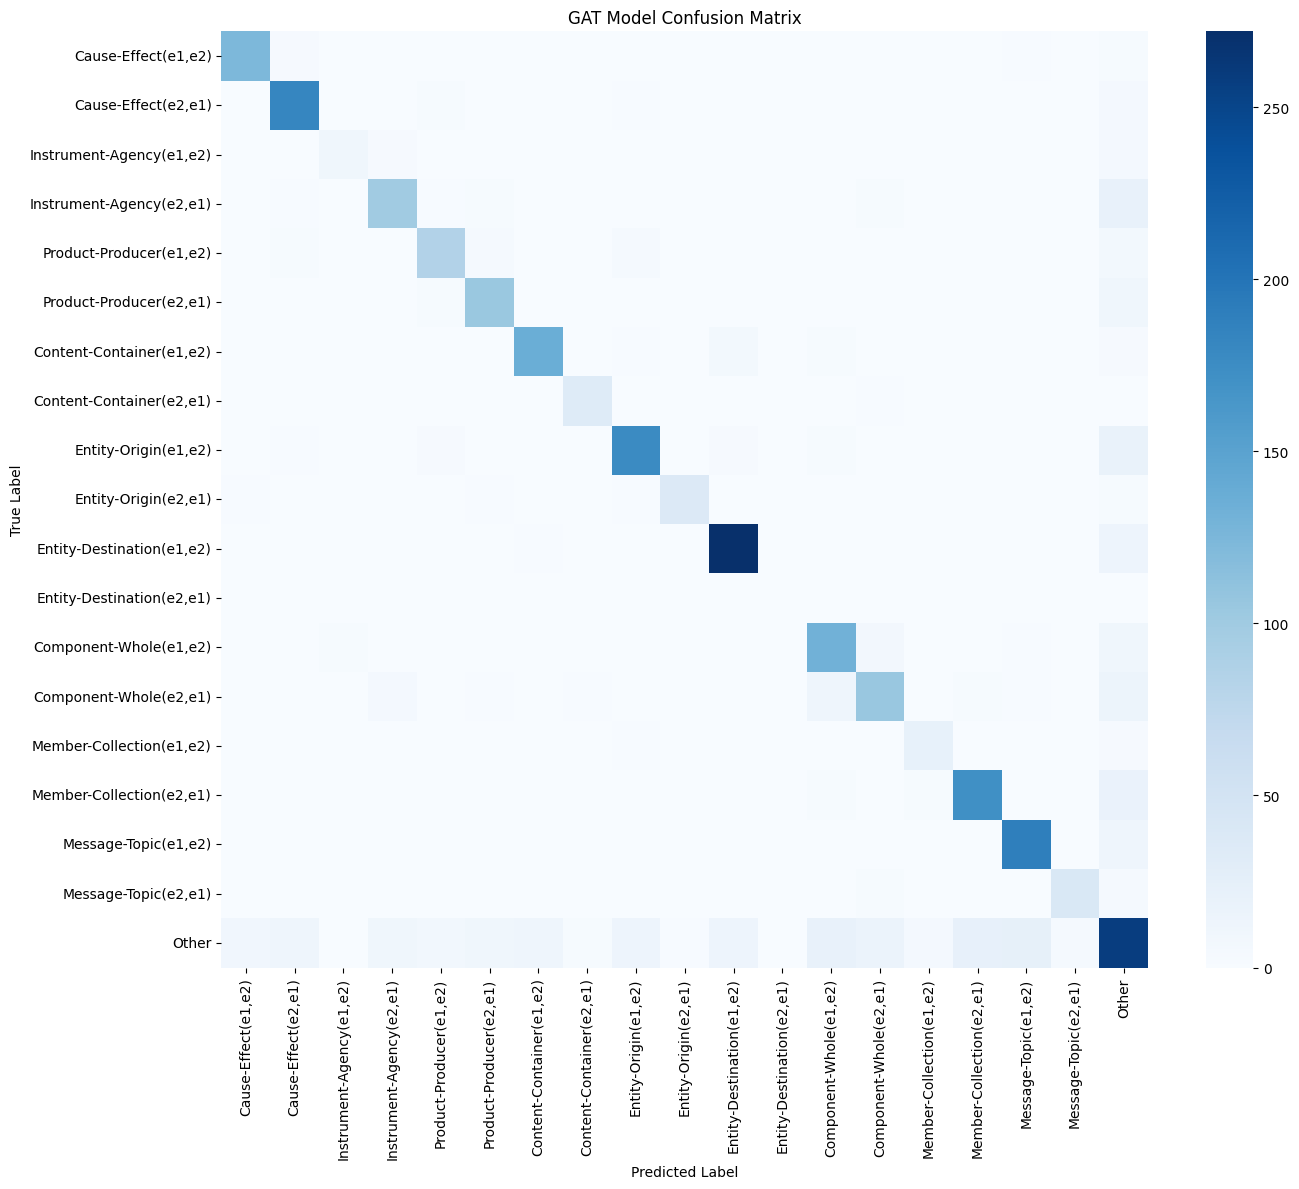

In [ ]:
print("\nGenerating Confusion Matrix for GAT Model...")
cm = confusion_matrix(gat_labels, gat_preds)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=RELATION_LABELS, yticklabels=RELATION_LABELS)
plt.title("GAT Model Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Extract Embeddings for t-SNE


t-SNE Extraction: 100%|██████████| 85/85 [00:29<00:00,  2.87it/s]


Running t-SNE


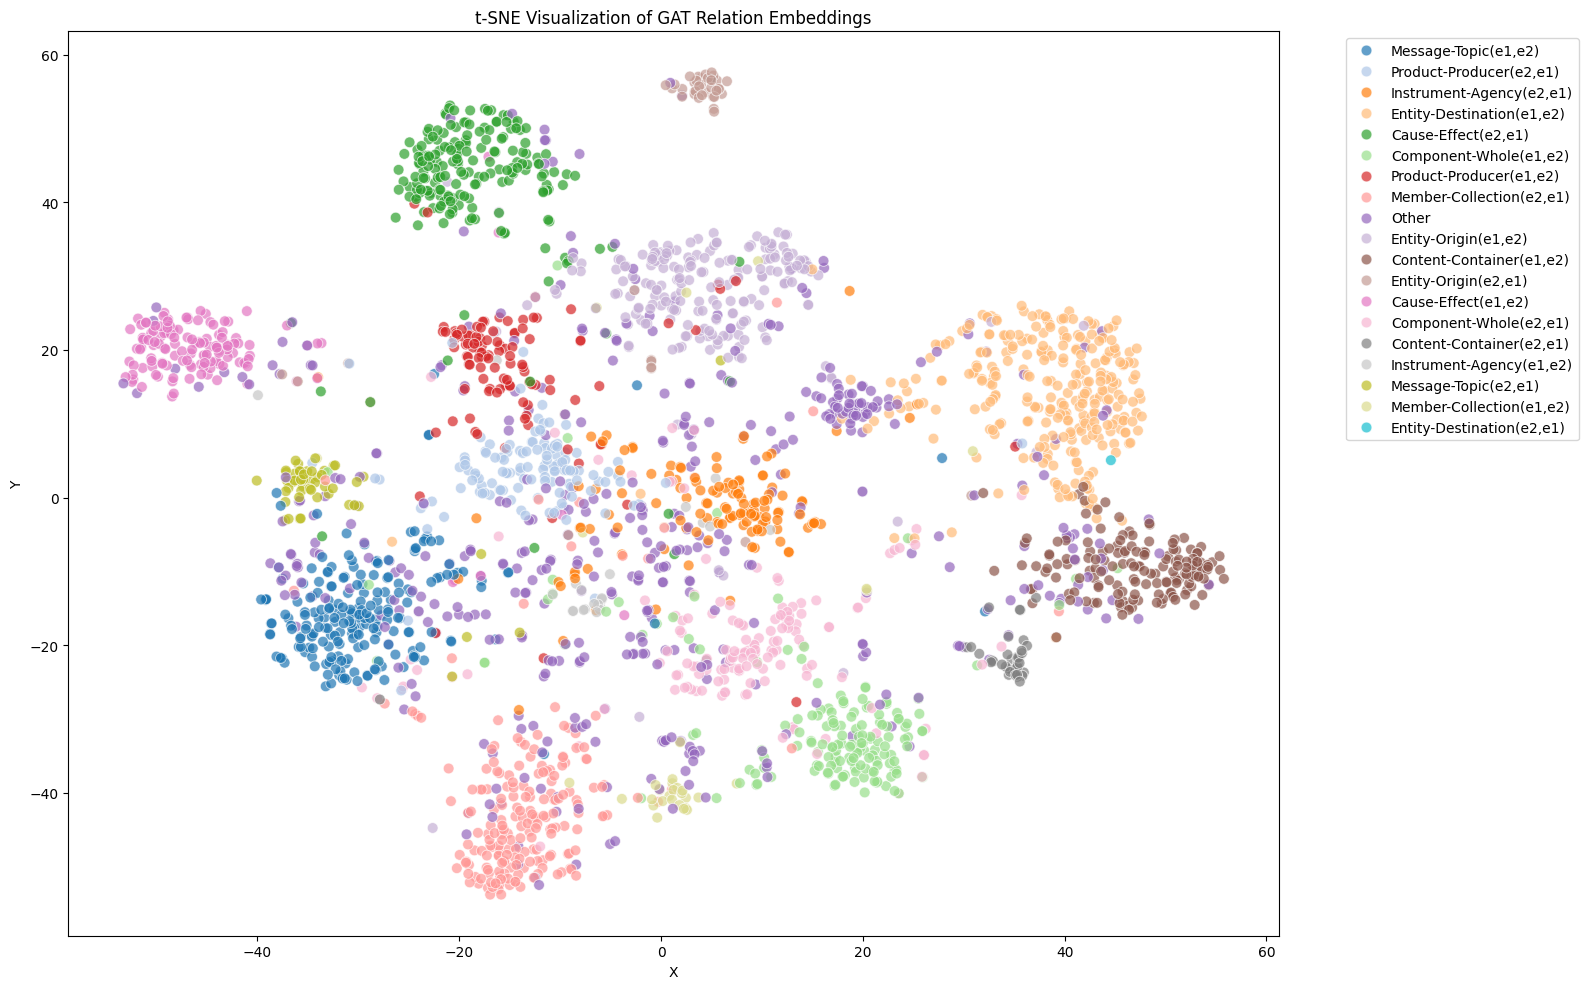

In [ ]:
from sklearn.manifold import TSNE

def plot_tsne(model,loader,device):
    model.eval()
    embeddings = []
    labels = []
    features = []
    def hook(module,input,output):
        features.append(input[0].cpu())
    handle = model.classifier[0].register_forward_hook(hook)

    print("Extract Embeddings for t-SNE")
    with torch.no_grad():
        for batch in tqdm(loader,desc="t-SNE Extraction"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            edge_index = batch['edge_index']
            batch_data = {'e1_idx': batch['e1_idx'], 'e2_idx': batch['e2_idx']}

            #Forward pass
            model(input_ids,mask,edge_index,batch_data)
            labels.extend(batch['label'].cpu().numpy())
    handle.remove()

    X = torch.cat(features).numpy()
    Y = np.array(labels)

    print("Running t-SNE")
    tsne = TSNE(n_components=2,random_state=42,perplexity=30,init='pca',learning_rate='auto')
    X_embedded = tsne.fit_transform(X)

    plt.figure(figsize=(16, 10))
    df_tsne = pd.DataFrame(X_embedded, columns=['X', 'Y'])
    df_tsne['label'] = [id_to_relation[i] for i in Y]

    sns.scatterplot(
        data=df_tsne, x='X', y='Y', hue='label',
        palette='tab20', alpha=0.7, s=60
    )
    plt.title("t-SNE Visualization of GAT Relation Embeddings")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_tsne(final_gat_model, test_loader, device)

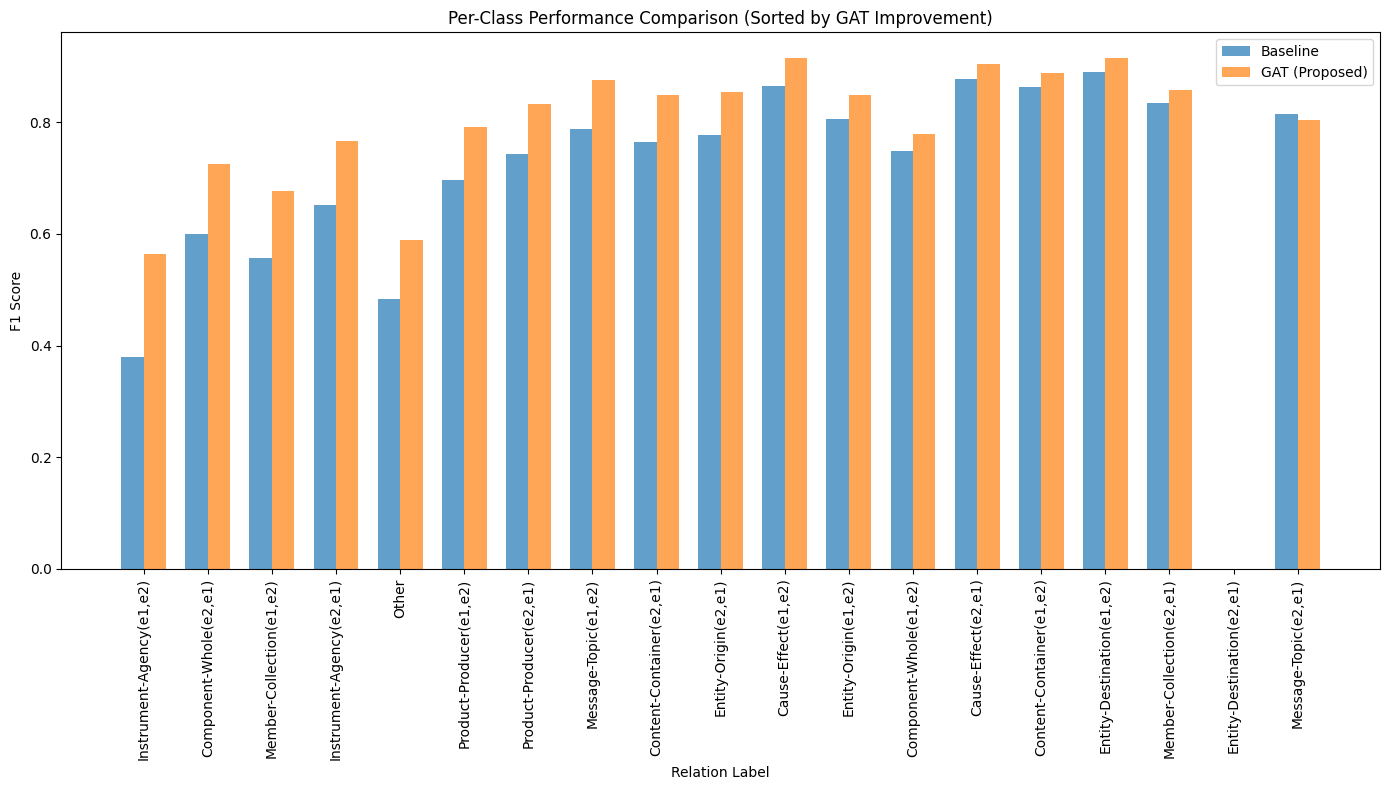

In [ ]:
_,_,base_f1_per_class,_ = precision_recall_fscore_support(baseline_labels,baseline_preds,average=None,zero_division=0)
_, _, gat_f1_per_class, _ = precision_recall_fscore_support(gat_labels, gat_preds, average=None, zero_division=0)
per_class_df = pd.DataFrame({'Relation':RELATION_LABELS,'Baseline F1':base_f1_per_class,'GAT F1':gat_f1_per_class})

per_class_df['Improvement'] = per_class_df['GAT F1'] - per_class_df['Baseline F1']
per_class_df = per_class_df.sort_values('Improvement', ascending=False)

plt.figure(figsize=(14, 8))
x = np.arange(len(RELATION_LABELS))
width = 0.35
plt.bar(x - width/2, per_class_df['Baseline F1'], width, label='Baseline', color='#1f77b4', alpha=0.7)
plt.bar(x + width/2, per_class_df['GAT F1'], width, label='GAT (Proposed)', color='#ff7f0e', alpha=0.7)
plt.xlabel('Relation Label')
plt.ylabel('F1 Score')
plt.title('Per-Class Performance Comparison (Sorted by GAT Improvement)')
plt.xticks(x, per_class_df['Relation'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


ACCURACY BY ENTITY DISTANCE
               Baseline_Correct  GAT_Correct
Bin                                         
Short (0-5)               76.11        81.78
Medium (6-10)             72.46        78.81
Long (11+)                65.57        72.13


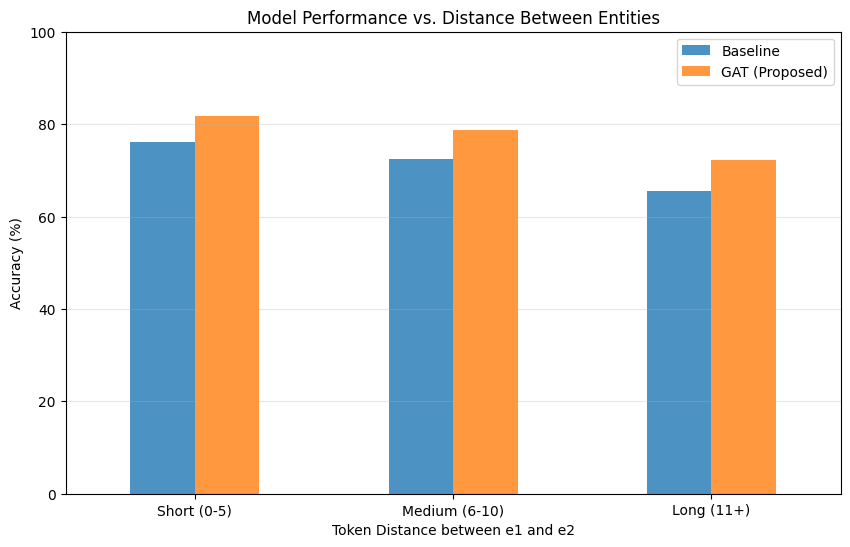

In [ ]:
test_labels = baseline_labels

def get_entity_distance(sentence):
    """Calculates number of words between <e1> and <e2>"""
    try:
        e1_end = sentence.find('</e1>')
        e2_start = sentence.find('<e2>')

        if e1_end < e2_start:
            between = sentence[e1_end+5 : e2_start]
        else:
            e2_end = sentence.find('</e2>')
            e1_start = sentence.find('<e1>')
            between = sentence[e2_end+5 : e1_start]

        return len(between.strip().split())
    except:
        return 0

distances = [get_entity_distance(s) for s in test_sentences]
correct_base = (np.array(baseline_preds) == np.array(baseline_labels))
correct_gat = (np.array(gat_preds) == np.array(gat_labels))

df_dist = pd.DataFrame({
    'Distance': distances,
    'Baseline_Correct': correct_base,
    'GAT_Correct': correct_gat
})

bins = [0, 5, 10, 50]
labels = ['Short (0-5)', 'Medium (6-10)', 'Long (11+)']
df_dist['Bin'] = pd.cut(df_dist['Distance'], bins=bins, labels=labels)

dist_analysis = df_dist.groupby('Bin')[['Baseline_Correct', 'GAT_Correct']].mean() * 100

print("\n" + "="*50)
print("ACCURACY BY ENTITY DISTANCE")
print("="*50)
print(dist_analysis.round(2))

ax = dist_analysis.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'], alpha=0.8)
plt.title('Model Performance vs. Distance Between Entities')
plt.ylabel('Accuracy (%)')
plt.xlabel('Token Distance between e1 and e2')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.legend(['Baseline', 'GAT (Proposed)'])
plt.xticks(rotation=0)
plt.show()

In [ ]:

print("\n" + "="*80)
print("GAT SUCCESS STORIES")
print("="*80)
print("Displaying sentences where Baseline FAILED but GAT SUCCEEDED:\n")

wins = np.where((correct_gat == True) & (correct_base == False))[0]

for i in wins[:3]:
    idx = i
    sent = test_sentences[idx]

    true_lbl = id_to_relation[test_labels[idx]]
    base_pred = id_to_relation[baseline_preds[idx]]
    gat_pred = id_to_relation[gat_preds[idx]]

    print(f"Sentence: {sent}")
    print(f"Distance: {distances[idx]} words")
    print(f"True Label:     {true_lbl}")
    print(f"Baseline Pred:  {base_pred} (Wrong)")
    print(f"GAT Pred:       {gat_pred} (Correct)")
    print("-" * 80)


GAT SUCCESS STORIES
Displaying sentences where Baseline FAILED but GAT SUCCEEDED:

Sentence: A child is told a <e1>lie</e1> for several years by their <e2>parents</e2> before he/she realizes that a Santa Claus does not exist.
Distance: 5 words
True Label:     Product-Producer(e1,e2)
Baseline Pred:  Other (Wrong)
GAT Pred:       Product-Producer(e1,e2) (Correct)
--------------------------------------------------------------------------------
Sentence: An FTP server is an inexpensive and relatively simple to operate tool that works great for <e1>filesharing</e1> over the <e2>internet</e2>.
Distance: 2 words
True Label:     Other
Baseline Pred:  Instrument-Agency(e1,e2) (Wrong)
GAT Pred:       Other (Correct)
--------------------------------------------------------------------------------
Sentence: The <e1>captain</e1> and the <e2>crew</e2> of the Steve Irwin are grateful for the support of the City of Fremantle and Mayor Brad Pettitt for hosting the event.
Distance: 2 words
True Label: 

In [ ]:
print("\n" + "="*80)
print("WHERE GAT STRUGGLES")
print("="*80)
print("Displaying sentences where GAT made a mistake(to understand limitations):\n")
failures = np.where(correct_gat==False)[0]
for i in failures[:3]:
    idx = i
    sent = test_sentences[idx]
    true_lbl = id_to_relation[test_labels[idx]]
    gat_pred = id_to_relation[gat_preds[idx]]
    print(f"Sentence:{sent}")
    print(f"True Label:{true_lbl}")
    print(f"GAT Prediction:{gat_pred}(Wrong)")
    print("-"*80)


WHERE GAT STRUGGLES
Displaying sentences where GAT made a mistake(to understand limitations):

Sentence:On a friend's advice, I purchased a sauerkraut and <e1>kimchi</e1> <e2>maker</e2> here and it is just fabulous (and cheap too).
True Label:Other
GAT Prediction:Product-Producer(e1,e2)(Wrong)
--------------------------------------------------------------------------------
Sentence:The same <e1>effect</e1> is achieved the traditional <e2>way</e2>, with a team of workers like Keebler elves.
True Label:Cause-Effect(e2,e1)
GAT Prediction:Other(Wrong)
--------------------------------------------------------------------------------
Sentence:He has built a formidable reputation writing powerful <e1>dramas</e1> for the stage and screen, based on <e2>real events</e2> or socially vital issues.
True Label:Other
GAT Prediction:Message-Topic(e1,e2)(Wrong)
--------------------------------------------------------------------------------


Visualizing Attention for a Test Sentence:


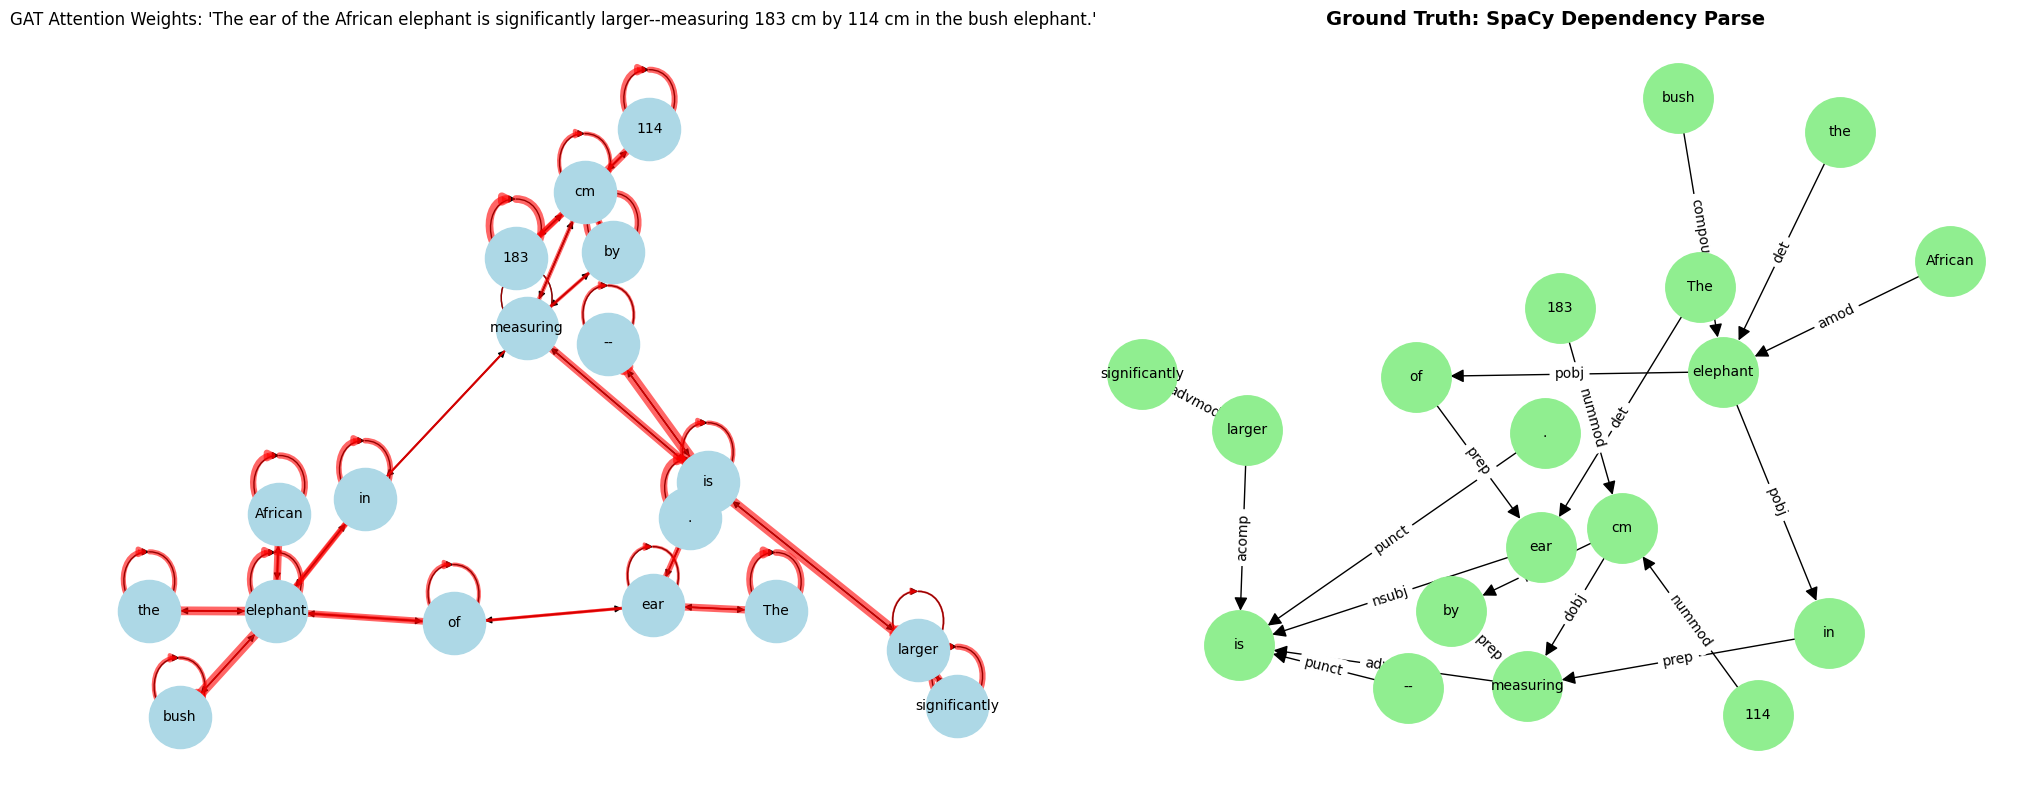

In [ ]:

import networkx as nx

def visualize_attention(sentence,model):
    clean_sent, _, _ = extract_entities(sentence)
    encoded = tokenizer(clean_sent, return_tensors='pt', max_length=128, truncation=True, padding='max_length')
    input_ids = encoded['input_ids'].to(device)
    mask = encoded['attention_mask'].to(device)
    edge_index, _ = build_dependency_graph(clean_sent)
    batch_data = {'e1_idx': [0], 'e2_idx': [0]}

    model.eval()
    with torch.no_grad():
        _,attn_data = model(input_ids,mask,[edge_index],batch_data,return_attention=True)

    edges,alpha = attn_data[0]

    weights = alpha.mean(dim=1).cpu().numpy()
    edges = edges.cpu().numpy()

    plt.figure(figsize=(20,8))
    plt.subplot(1, 2, 1)
    G = nx.DiGraph()
    doc = nlp(clean_sent)
    token_list = [t.text for t in doc]

    for i, (src, dst) in enumerate(zip(edges[0], edges[1])):
        if src < len(token_list) and dst < len(token_list):
            w = weights[i]
            if w > 0.05:
                G.add_edge(token_list[src], token_list[dst], weight=w*10)

    pos = nx.spring_layout(G, k=0.5)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10)

    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    nx.draw_networkx_edges(G, pos, width=weights, edge_color='r', alpha=0.6)
    plt.title(f"GAT Attention Weights: '{clean_sent}'")
    plt.subplot(1, 2, 2)
    G_dep = nx.DiGraph()
    for token in doc:
        if token.head.i != token.i:
            G_dep.add_edge(token.text, token.head.text, label=token.dep_)

    pos_dep = nx.spring_layout(G_dep, k=0.6, seed=42)
    nx.draw(G_dep, pos_dep, with_labels=True, node_color='lightgreen', node_size=2500, font_size=10, arrowsize=20)
    nx.draw_networkx_edge_labels(G_dep, pos_dep, edge_labels=nx.get_edge_attributes(G_dep, 'label'), font_color='black')
    plt.title("Ground Truth: SpaCy Dependency Parse", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

print("Visualizing Attention for a Test Sentence:")
visualize_attention(test_sentences[5], final_gat_model)